In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
from shapely.geometry import Polygon
from skimage import draw
import copy
import random
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
import ml_collections
import torch.optim as optim

In [2]:
config = {
    'patches_size': 128,
    'allow_padding': True,
    'target_label': 'glomerulus',
    'img_channels': 3   # Number of color channels, Grayscale = 1 / RGB = 3
}

class DatasetPatch():
    def __init__(self, center_x, center_y, theta, patches_size):
        self.center_x = center_x
        self.center_y = center_y
        self.theta = theta
        
#     def render(self, img):
        

class DatasetImage():
    def __init__(self, image_path, config):
        self.config = config
        self.image = self._read_tiff(image_path)
        
    def _read_tiff(self, image_path):
        with rasterio.open(image_path) as image:
            image = image.read().astype(np.float32) / 255
            return image

In [33]:
class Glomerulus():
    def __init__(self, coordinates):
        self.coordinates = np.array(coordinates)
        centroid = self._compute_centroid(coordinates)
        self.centroid_y, self.centroid_x = centroid.y, centroid.x
        
    def _compute_centroid(self, coordinates):
        polygon = Polygon(coordinates)
        return polygon.centroid
    
    def __repr__(self):
        return f'Glomerulus(centroid_x={self.centroid_x}, centroid_y={self.centroid_y})'
    
    
def get_glomeruli(json_path, target_label):
    label_json = json.load(open(json_path))
    glomeruli = []
    for element in label_json:
        if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
            label = element['geometry']
            if label['type'] == 'Polygon' and element['properties']['classification']['name'] == target_label:
                glomeruli.append(Glomerulus(label['coordinates'][0]))
    return glomeruli

# Stores only patch location and rotation to save memory
class Patch():
    def __init__(self, center_x, center_y, theta, patch_size, glomeruli, image):
        self.center_x = center_x
        self.center_y = center_y
        
        self.theta = theta
        self.patch_size = patch_size
        
        self.image = image
        self.glomeruli = glomeruli
        
    def _rotate(self, image, angle):
        # Get center of sliced image and rotation matrix
        center = (image.shape[2] // 2, image.shape[1] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Apply rotation
        rotated_image = np.zeros_like(image)
        for idx in range(image.shape[0]):
            rotated_image[idx] = cv2.warpAffine(
                image[idx], 
                rotation_matrix, 
                (image.shape[2], image.shape[1])
            )
        return rotated_image
    
    # TODO: Optimize by only rendering glomeruli appeared in the mask
    # Renders image binary mask using given image array and patch's coordinate and rotation
    def render_mask(self):
        cell_center_x = int(round(self.center_x))
        cell_center_y = int(round(self.center_y))
        
        # Calculate slicing size that ensures patch will fit with any rotation
        half_slicing_size = int(np.ceil(self.patch_size * np.sqrt(2))) + 1
        
        slicing_size = half_slicing_size * 2
        
        half_patch_size = self.patch_size // 2
        
        padded_base = np.zeros((1, slicing_size, slicing_size), dtype=bool)
        
        for glomerulus in self.glomeruli:
            distance_x = np.abs(glomerulus.centroid_x - self.center_x)
            distance_y = np.abs(glomerulus.centroid_y - self.center_y)
            distance = np.sqrt(distance_x**2 + distance_y**2)
            
            if distance < slicing_size:
                coordinates = copy.deepcopy(glomerulus.coordinates)
                for idx in range(len(coordinates)):
                    coordinates[idx] = np.array([
                        coordinates[idx][0] - cell_center_x + half_slicing_size, 
                        coordinates[idx][1] - cell_center_y + half_slicing_size
                    ], dtype=int)

                binary_mask = np.array(draw.polygon2mask(
                    (slicing_size, slicing_size),
                    np.flip(coordinates, axis=None)
                ), dtype=bool)

                binary_mask = np.expand_dims(binary_mask, axis=0)
                padded_base |= binary_mask
            
        rotated_binary_mask = self._rotate(padded_base.astype(float), self.theta)
        
        # Crop rotated patch to correct patch size
        half_patch_size = self.patch_size // 2
        
        center = (rotated_binary_mask.shape[2] // 2, rotated_binary_mask.shape[1] // 2)
        
        x_tl = center[0] - half_patch_size
        y_tl = center[1] - half_patch_size
        x_br = center[0] + half_patch_size
        y_br = center[1] + half_patch_size
        
        return rotated_binary_mask[:, y_tl:y_br, x_tl:x_br]
    
    # Renders image array using given image array and patch's coordinate and rotation
    def render_image(self):
        # Get center coordinates snapped to cell coordinates
        cell_center_x = int(round(self.center_x))
        cell_center_y = int(round(self.center_y))
        
        # Calculate slicing size that ensures patch will fit with any rotation
        half_slicing_size = int(np.ceil(self.patch_size * np.sqrt(2))) + 1
        
        # X/Y Top-left
        x_tl = cell_center_x - half_slicing_size
        y_tl = cell_center_y - half_slicing_size
        
        # Calculate needed top-left paddings
        x_pad_tl = - min(0, x_tl)
        y_pad_tl = - min(0, y_tl)
        
        # Limit top-left coordinates to within image indices
        x_tl = max(0, x_tl)
        y_tl = max(0, y_tl)
        
        # X/Y Bottom-right
        x_br = cell_center_x + half_slicing_size
        y_br = cell_center_y + half_slicing_size
        
        # Calculate needed bottom-right paddings
        x_pad_br = max(0, x_br - (self.image.shape[2] - 1))
        y_pad_br = max(0, y_br - (self.image.shape[1] - 1))
        
        # Limit bottom-right coordinates to within image indices
        x_br = min(self.image.shape[2] - 1, x_br)
        y_br = min(self.image.shape[1] - 1, y_br)
                   
        slicing_size = half_slicing_size * 2
        
        # Get sliced image without padding
        sliced_image = self.image[:, y_tl:y_br, x_tl:x_br]
        
        # Get 2d array with correct size and add sliced image to it at the appropriate location
        padded_sliced_image = np.zeros((self.image.shape[0], slicing_size, slicing_size))
        padded_sliced_image[:, y_pad_tl:slicing_size - y_pad_br, x_pad_tl:slicing_size - x_pad_br] = sliced_image
        
        rotated_image = self._rotate(padded_sliced_image, self.theta)
            
        # Crop rotated patch to correct patch size
        half_patch_size = self.patch_size // 2
        
        center = (rotated_image.shape[2] // 2, rotated_image.shape[1] // 2)
        
        x_tl = center[0] - half_patch_size
        y_tl = center[1] - half_patch_size
        x_br = center[0] + half_patch_size
        y_br = center[1] + half_patch_size
        
        return rotated_image[:, y_tl:y_br, x_tl:x_br]

def generate_glomerulus_patches(patch_size, num_patches, glomeruli, image):
    patches = []
    for _ in tqdm(range(num_patches)):
        glomeruli_num = len(glomeruli)
        glomerulus = glomeruli[random.randrange(0, glomeruli_num)]
        
        half_patch_size = patch_size / 2 + 50
        center_x = random.randrange(
            int(glomerulus.centroid_x - half_patch_size), 
            int(glomerulus.centroid_x + half_patch_size)
        )
        
        center_y = random.randrange(
            int(glomerulus.centroid_y - half_patch_size),
            int(glomerulus.centroid_y + half_patch_size)
        )
        
        theta = random.random()*360
        
        patches.append(Patch(
            center_x = center_x,
            center_y = center_y,
            theta = theta,
            patch_size = patch_size,
            glomeruli = glomeruli,
            image = image
        ))
    return patches

In [35]:
class KidneyDataset():
    def __init__(self, patches):
        self.patches = patches
    def __getitem__(self, idx):
        # Handle slicing, repeatedly call index version of the function
        if isinstance(idx, slice):
            return [self[ii] for ii in iter(range(*idx.indices(len(self))))]

        # Handle index
        elif isinstance(idx, int):
            return self.patches[idx].render_image(), self.patches[idx].render_mask()
        
    def __len__(self):
        return len(self.patches)

In [36]:
from torchvision.models import resnet50, ResNet50_Weights

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
#         resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
#         encoder_layers = list(resnet.children())[:-1]
#         self.resnet50_encoder = torch.nn.Sequential(*encoder_layers)
        
#         for param in self.resnet50_encoder.parameters():
#             param.requires_grad = False
        
        self.sequential = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
#             nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, stride=2),
            nn.ReLU(),
        )
        
    def forward(self, x):
#         out = self.resnet50_encoder.forward(x)
#         out = torch.reshape(out, (out.size(0), 512, 2, 2))
#         out = self.decoder.forward(out)
        out = self.sequential(x)
        return out


In [37]:
class Block(nn.Module):
    def __init__(self, layer_type, in_channels, out_channels, hidden_channels, num_layers, activation_type, negative_slope=0.01, kernel_size=3):
        super().__init__()
        layers = []

        for _ in range(num_layers):
            if not _:
                layer_in_channels = in_channels
            else:
                layer_in_channels = hidden_channels
                
            if _ < num_layers - 1:
                layer_out_channels = hidden_channels
            else:
                layer_out_channels = out_channels
                
            match layer_type:
                case 'Conv2d':
                    layer = nn.Conv2d(
                        layer_in_channels, 
                        layer_out_channels, 
                        kernel_size = kernel_size,
                        padding = 1
                    )
                case 'ConvTranspose2d':
                    layer = nn.ConvTranspose2d(
                        layer_in_channels, 
                        layer_out_channels, 
                        kernel_size = kernel_size,
                        padding = 1
                    )
                case 'Linear':
                    layer = nn.Linear(
                        layer_in_channels, 
                        layer_out_channels
                    )
            match activation_type:
                case 'ReLU':
                    activation = nn.ReLU()
                case 'LeakyReLU':
                    activation = nn.LeakyReLU(negative_slope = negative_slope)
                case 'Sigmoid':
                    activation = nn.Sigmoid()
            layers.append(layer)
            layers.append(nn.BatchNorm2d(layer_out_channels))
            layers.append(activation)
        self.sequential = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.sequential.forward(x)

# UNet based on https://bmcbiomedeng.biomedcentral.com/articles/10.1186/s42490-021-00050-y
class UNet(nn.Module):
    def __init__(self, input_size=(128, 128), output_size=(128, 128)):
        super().__init__()
        
        self.transform_input_1 = nn.AdaptiveAvgPool2d(input_size)
        self.transform_output = nn.AdaptiveAvgPool2d(output_size)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upscale = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.encode_1 = Block(
            layer_type = 'Conv2d',
            in_channels = 1, 
            out_channels = 16,
            hidden_channels = 16,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.encode_2 = Block(
            layer_type = 'Conv2d',
            in_channels = 16, 
            out_channels = 32,
            hidden_channels = 32,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.encode_3 = Block(
            layer_type = 'Conv2d',
            in_channels = 32, 
            out_channels = 64, 
            hidden_channels = 64,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.encode_4 = Block(
            layer_type = 'Conv2d',
            in_channels = 64, 
            out_channels = 128, 
            hidden_channels = 128,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.encode_5 = Block(
            layer_type = 'Conv2d',
            in_channels = 128, 
            out_channels = 128, 
            hidden_channels = 256 ,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.decode_1 = Block(
            layer_type = 'Conv2d',
            in_channels = 256, 
            out_channels = 64, 
            hidden_channels = 128,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.decode_2 = Block(
            layer_type = 'Conv2d',
            in_channels = 128, 
            out_channels = 32, 
            hidden_channels = 64,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.decode_3 = Block(
            layer_type = 'Conv2d',
            in_channels = 64, 
            out_channels = 16, 
            hidden_channels = 32,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.decode_4 = Block(
            layer_type = 'Conv2d',
            in_channels = 32, 
            out_channels = 16, 
            hidden_channels = 16,
            num_layers = 2,
            activation_type = 'ReLU'
        )
        
        self.generate = Block(
            layer_type = 'Conv2d',
            in_channels = 16, 
            out_channels = 1,
            hidden_channels = 1,
            num_layers = 1,
            activation_type = 'Sigmoid',
            kernel_size = 3
        )
    def forward(self, x):
        
        in_1 = self.transform_input_1(x)
        out_1 = self.encode_1(in_1)
        skip_1 = out_1.detach().clone()
        out_1 = self.pool(out_1)
        
        out_2 = self.encode_2(out_1)
        skip_2 = out_2.detach().clone()
        out_2 = self.pool(out_2)
        
        out_3 = self.encode_3(out_2)
        skip_3 = out_3.detach().clone()
        out_3 = self.pool(out_3)
        
        out_4 = self.encode_4(out_3)
        skip_4 = out_4.detach().clone()
        out_4 = self.pool(out_4)
        
        out_5 = self.encode_5(out_4)
        out_5 = self.upscale(out_5)
        
        out_6 = self.decode_1(torch.cat((skip_4, out_5), 1))
        out_6 = self.upscale(out_6)
        
        out_7 = self.decode_2(torch.cat((skip_3, out_6), 1))
        out_7 = self.upscale(out_7)
        
        out_8 = self.decode_3(torch.cat((skip_2, out_7), 1))
        out_8 = self.upscale(out_8)
        
        out_9 = self.decode_4(torch.cat((skip_1, out_8), 1))
        
        out = self.generate(out_9)
        return self.transform_output(out)
    
UNet((128, 128), (128, 128)).forward(torch.randn(1, 1, 128, 128)).size()

torch.Size([1, 1, 128, 128])

In [38]:
import gc
dimension = 512
dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
gc.collect()

cuda


364

In [9]:
TEST_IMAGE_PATH = './kidney_dataset/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/aaa6a05cc.json'

TRAIN_IMAGE_PATH = './kidney_dataset/train/2f6ecfcdf.tiff'
TRAIN_LABEL_PATH = './kidney_dataset/train/2f6ecfcdf.json'

# Reads and convert image array to grayscale if needed
def read_tiff(image_path):
    with rasterio.open(image_path) as image:
        image_data = image.read().astype(np.float32)
        
        if image_data.shape[0] == 1:
            image_data /= 255.0
        else:
            image_data = np.average(
                image_data, 
                axis=0, 
                weights=[0.299, 0.587, 0.144]
            )
            
            image_data = np.expand_dims(image_data, axis=0)
            
        # Histogram Equalization (takes too long and too much memory to do)
            
#         hist, bins = np.histogram(image_data.flatten(), bins=256, range=[0, 1])
#         cdf = hist.cumsum(dtype=np.float32)
#         cdf_normalized = cdf / cdf[-1]
#         equalized_image = np.interp(image_data.flatten(), bins[:-1], cdf_normalized)
#         equalized_image = equalized_image.reshape(image_data.shape)
            
        return image_data.astype(np.float32)
test_image = read_tiff(TEST_IMAGE_PATH)
train_image = read_tiff(TRAIN_IMAGE_PATH)

C:\Users\iraha\anaconda3\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


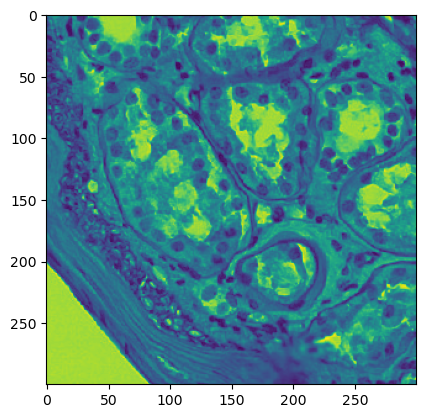

In [39]:
plt.imshow(np.transpose(test_image[:, 5500:5800, 5500:5800], (1, 2, 0)))

In [69]:
train_glomeruli = get_glomeruli(TRAIN_LABEL_PATH,'glomerulus')
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')

train_patches = generate_glomerulus_patches(
    patch_size = dimension,
    num_patches = 1000,
    glomeruli = train_glomeruli,
    image = train_image
)

test_patches = generate_glomerulus_patches(
    patch_size = dimension,
    num_patches = 100,
    glomeruli = test_glomeruli,
    image = test_image
)

train_dataset = KidneyDataset(train_patches)
val_dataset = KidneyDataset(test_patches)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)

model = UNet((128, 128), (512, 512)).cuda()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
import gc
def adjusted_mse(output, target, label_mean):
    loss = torch.mean(((output - target) * torch.where(target < 0.5, 1/label_mean, 1/(1-label_mean)))**2)
    return loss

# Calculate average of mask labels, use to weight loss accordingly
label_sum = 0
for idx in tqdm(range(len(train_dataset)), desc='Dataset Mean'):
    label_sum += np.sum(train_dataset[idx][1])/(train_dataset[idx][1].shape[1]*train_dataset[idx][1].shape[2])
label_mean = label_sum / len(train_dataset)


def train(model, epochs=100):
    gc.collect()
    torch.cuda.empty_cache()
    
    best_weights = None
    best_loss = 10000000

    # Load pretrained weights

    train_loss = []
    val_loss = []

    criterion = adjusted_mse
    optimizer = optim.Adam(model.parameters(), lr=0.008)
    pbar = tqdm(total=epochs, desc='Training')
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        
        for inputs, labels in train_dataloader:
            gc.collect()
            torch.cuda.empty_cache()
            # Move data to GPU
            inputs = inputs.type(dtype)
            labels = labels.type(dtype)
            # Run model
            outputs = model.forward(inputs)

            loss = criterion(outputs, labels, label_mean)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
            
        train_epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(train_epoch_loss)

        # Val
        model.eval()
        running_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                gc.collect()
                torch.cuda.empty_cache()
                # Move data to GPU
                inputs = inputs.type(dtype)
                labels = labels.type(dtype)
                # Run model
                outputs = model.forward(inputs)

                loss = criterion(outputs, labels, label_mean)
                running_loss += loss.item()
        val_epoch_loss = running_loss / len(val_dataloader)
        val_loss.append(val_epoch_loss)
        
        pbar.set_postfix({'Train Loss': train_epoch_loss, 'Val Loss': val_epoch_loss})
        pbar.update(1)
        
        # Save model every 10 epochs
        if (epoch + 1)%10 == 0:
            torch.save(model.state_dict(), f'./models/UNet_{str(epoch+1)}.npz')
            
        # Keep track of best weights
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_weights = model.state_dict()
    # Save weights with best loss
    torch.save(best_weights, f'./models/UNet_best_loss.npz')
    return model, train_loss, val_loss
# For debugging
torch.autograd.set_detect_anomaly(True)

# Train model
model, train_loss, val_loss = train(model, epochs=100)

Dataset Mean:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

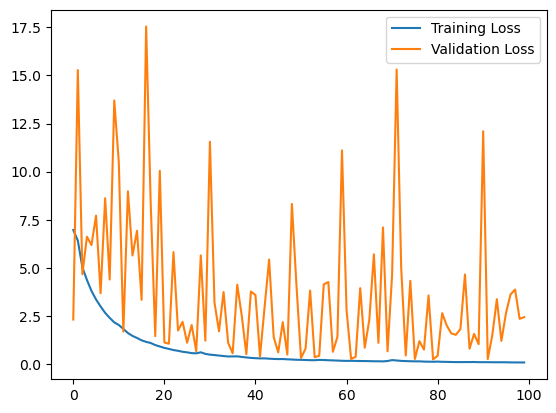

In [71]:
plt.plot(np.arange(100), train_loss, label='Training Loss')
plt.plot(np.arange(100), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.show()

In [72]:
label_mean

0.154502018943429

In [73]:
# torch.save(model.state_dict(), 'trained_model.npz')
model.load_state_dict(torch.load('./models/UNet_best_loss.npz'))

<All keys matched successfully>

Text(0.5, 1.0, 'Ground Truth')

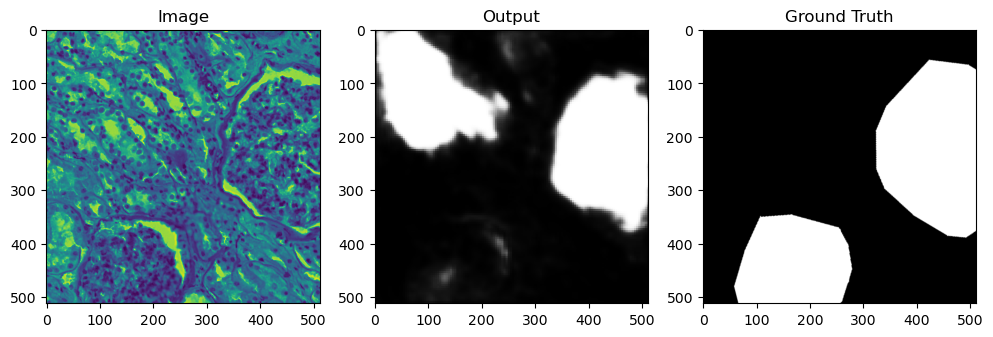

In [77]:
ID = 0
out = model.forward(rgb_to_grayscale(torch.tensor([val_dataset[ID][0]]).type(dtype)))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(val_dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(val_dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')

Text(0.5, 1.0, 'Ground Truth')

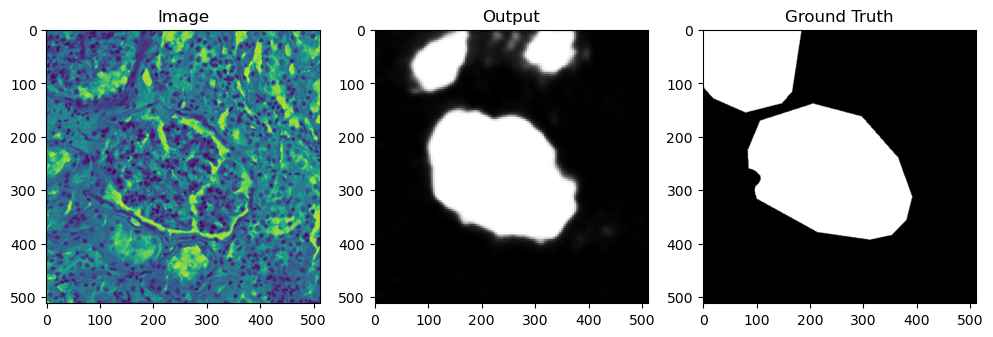

In [79]:
ID = 2
out = model.forward(rgb_to_grayscale(torch.tensor([val_dataset[ID][0]]).type(dtype)))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(val_dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(val_dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')

Text(0.5, 1.0, 'Ground Truth')

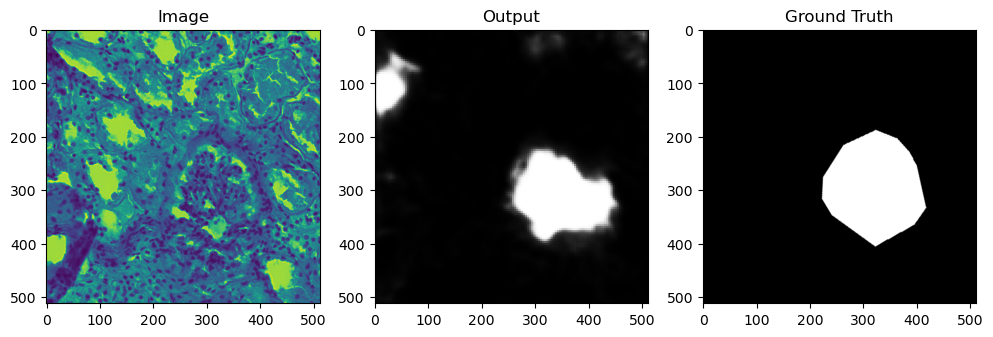

In [81]:
ID = 22
out = model.forward(rgb_to_grayscale(torch.tensor([val_dataset[ID][0]]).type(dtype)))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(val_dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(val_dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')

In [ ]:
bidirectional feaature pyramaid
cbam/bam + r2u-net
re-center output glomeruli and rerun to fix badly cropped edges
make model aware of glomeruli size or filter out segmented glomeruli with sizes out of the norm